# Imports and Tensorflow set up

In [1]:
# workaround if you have not yet installed CherenkovDeconvolution.py but want to try it from this notebook
import sys
sys.path.insert(0,'/net/nfshome/home/shaefs/CherenkovDeconvolution.py')

In [2]:
from cherenkovdeconvolution import dsea

import numpy as np
np.random.seed(42)

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
import csv

In [3]:
with tf.compat.v1.Session() as sess:
  devices = sess.list_devices()
devices

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 1208033877609156827),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2402301664182601258),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 3293904896, 6629184282291103510),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:1, GPU, 22533160960, 13293268154104766105),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 7794060118265236071),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:1, XLA_GPU, 17179869184, 11232922804159165563)]

# Deep Neural Network

In [4]:
# train a new model or select existing model_weights
model_trained = True
weights_name = 'weights_feature_importance'

In [5]:
# neural network
def make_model(num_features, num_classes, learning_rate=0.0005):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(120, input_shape=num_features))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(240, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(12, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    # compile the NN
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metric = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

    model.compile(optimizer=opt, loss=loss, metrics=[metric])

    return model

# Read in feature list

In [6]:
path_featureList = '/net/nfshome/home/shaefs/NN_in_DSEA_Haefs/feature_selection/output/feature_importance.csv'
df_imp = pd.read_csv(path_featureList)
df_imp

,feature_name,feature_importance,std
0,I3MCWeightDict.OneWeight,0.466107,0.042258
1,I3MCWeightDict.TotalInteractionProbabilityWeight,0.088680,0.007833
2,SplineMPEDirectHitsD.dir_track_length,0.018239,0.009990
3,SplineMPEDirectHitsICB.n_late_doms,0.015740,0.009106
4,HitStatisticsValuesIC.q_tot_pulses,0.014089,0.010815
...,...,...,...
83,I3MCWeightDict.NEvents,0.000000,0.000000
84,weight_honda_h4a,0.000000,0.000000
85,weight_ERS_h3a,0.000000,0.000000
86,weight_ERS_h4a,0.000000,0.000000


In [7]:
feature_list = df_imp['feature_name'][2:69].tolist()

# Read-in data and preprocessing

In [8]:
# just read-in necessary columns
fields = feature_list + ['MCPrimary.energy']

In [9]:
# read in data
file_path = '/net/big-tank/POOL/users/lkardum/new_mc_binning.csv'
df_raw = pd.read_csv(file_path, skipinitialspace=True, usecols=fields)

df_raw

,SplineMPE.zenith,SplineMPE.azimuth,SplineMPEFitParams.nmini,SPEFit2TimeSplit1FitParams.logl,SplineMPECramerRaoParams.variance_theta,SplineMPECramerRaoParams.covariance_theta_phi,SplineMPECramerRaoParams.covariance_theta_y,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,SPEFit2BayesianFitParams.nmini,MuEXAngular4_rllt.value,...,SplineMPE_MillipedeHighEnergyMIEFitParams.rlogl,SplineMPEDirectHitsD.dir_track_length,SPEFit2_HVFitParams.nmini,SplineMPETruncatedEnergy_SPICEMie_AllBINS_Muon.energy,LineFitGeoSplit2.zenith,SplineMPETruncatedEnergy_SPICEMie_AllBINS_Neutrino.energy,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_Muon.energy,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_dEdX.value
0,2.173209,1.450835,125.0,123.124257,0.000138,0.000037,-0.032945,20601.845970,231.0,7.049173,...,0.139320,685.779668,137.0,2526.835938,2.221959,40368.382177,1447.295371,0.175000,0.022686,0.131812
1,2.090220,2.636622,200.0,237.086697,0.003101,0.000668,0.033042,9461.487291,298.0,6.561541,...,0.099896,441.042202,92.0,630.132299,2.423724,20111.257701,479.612347,0.057143,0.097690,0.061557
2,2.152436,6.229766,206.0,38.646277,0.000325,-0.000076,-0.006858,43222.679757,345.0,6.417585,...,0.114078,693.142713,91.0,257.239972,2.078402,13655.266052,1131.508113,0.217391,0.049914,0.110715
3,1.526620,3.151964,229.0,63.513442,0.000066,-0.000123,-0.010941,9929.465219,196.0,6.490540,...,0.096490,812.617801,202.0,485.507753,1.602885,17895.872473,292.290969,0.875000,0.023061,0.044473
4,2.918809,4.037246,256.0,56.986199,0.001243,-0.000424,0.007623,14979.867844,266.0,5.739560,...,0.077930,481.401233,129.0,357.565624,3.141593,15674.452573,405.179483,0.294118,0.222784,0.055048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,2.172118,6.277671,219.0,49.769049,0.002613,-0.000850,0.019735,28988.905556,353.0,5.743283,...,0.119279,460.052098,80.0,4458.926101,2.299896,56523.447307,1148.094892,0.000000,0.149460,0.111854
13336409,1.793314,0.869684,279.0,218.336336,0.000112,-0.000024,-0.029691,13010.699980,702.0,6.835591,...,0.210637,687.935414,108.0,9210.806478,1.722485,93603.851895,716.027905,0.555556,0.134817,0.080649
13336410,2.338623,5.743147,314.0,73.113221,0.010503,-0.000857,-0.138076,15232.377792,269.0,6.303238,...,0.130154,450.014305,78.0,6471.678978,2.221949,72282.799275,996.351714,0.125000,0.090354,0.101285
13336411,2.297157,0.333139,214.0,84.905412,0.004765,0.002826,-0.028317,19444.610677,643.0,6.239686,...,0.093497,285.164319,81.0,1254.425580,1.728248,27903.240772,457.295637,0.000000,0.128185,0.059637


In [10]:
# drop critical rows
df = df_raw.drop([ 1007671,  1426233,  2304853,  2715790,  3674355,  3741687, 4178063,  4969266,  5038333,  5334552,  5589516,  5863719,
 5978972,  7006367,  7281704,  7509650,  8380383,  8758113,9043798, 10280382, 11179530, 11184928, 11332586, 11797767,12253944], axis = 0)

# substitute NaNs with extreme Value
df.fillna(value =-100000, inplace = True)

In [11]:
# plot correlations between the features

# plt.figure(figsize=(200,200))
# ax = sns.heatmap(df[feature_list].corr(), annot=True, square=True, cmap='coolwarm')

# #fix bug in matlotlib 3.1.0/1
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)
# plt.savefig('output/feature_cor.pdf')
# plt.show()

# Discretize the target Neutrino Energy

In [12]:
# discretize
df['MCPrimary.energy'].describe()

count    1.333639e+07
mean     6.298949e+03
std      2.457562e+05
min      1.000001e+02
25%      2.706783e+02
50%      5.471676e+02
75%      1.416143e+03
max      9.970067e+07
Name: MCPrimary.energy, dtype: float64

In [13]:
# Variables: Label
# drop out all events with Energies outside the range
lower_limit = 100
upper_limit = 10**5

# Variables: NN
num_bins = 10 # number of bins (energy classes), output_shape

In [14]:
# throw out extreme high and low energy neutrinos
df = df[(df['MCPrimary.energy']<upper_limit) & (df['MCPrimary.energy']>lower_limit)]
df

,SplineMPE.zenith,SplineMPE.azimuth,SplineMPEFitParams.nmini,SPEFit2TimeSplit1FitParams.logl,SplineMPECramerRaoParams.variance_theta,SplineMPECramerRaoParams.covariance_theta_phi,SplineMPECramerRaoParams.covariance_theta_y,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,SPEFit2BayesianFitParams.nmini,MuEXAngular4_rllt.value,...,SplineMPE_MillipedeHighEnergyMIEFitParams.rlogl,SplineMPEDirectHitsD.dir_track_length,SPEFit2_HVFitParams.nmini,SplineMPETruncatedEnergy_SPICEMie_AllBINS_Muon.energy,LineFitGeoSplit2.zenith,SplineMPETruncatedEnergy_SPICEMie_AllBINS_Neutrino.energy,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_Muon.energy,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_dEdX.value
0,2.173209,1.450835,125.0,123.124257,0.000138,0.000037,-0.032945,20601.845970,231.0,7.049173,...,0.139320,685.779668,137.0,2526.835938,2.221959,40368.382177,1447.295371,0.175000,0.022686,0.131812
1,2.090220,2.636622,200.0,237.086697,0.003101,0.000668,0.033042,9461.487291,298.0,6.561541,...,0.099896,441.042202,92.0,630.132299,2.423724,20111.257701,479.612347,0.057143,0.097690,0.061557
2,2.152436,6.229766,206.0,38.646277,0.000325,-0.000076,-0.006858,43222.679757,345.0,6.417585,...,0.114078,693.142713,91.0,257.239972,2.078402,13655.266052,1131.508113,0.217391,0.049914,0.110715
3,1.526620,3.151964,229.0,63.513442,0.000066,-0.000123,-0.010941,9929.465219,196.0,6.490540,...,0.096490,812.617801,202.0,485.507753,1.602885,17895.872473,292.290969,0.875000,0.023061,0.044473
4,2.918809,4.037246,256.0,56.986199,0.001243,-0.000424,0.007623,14979.867844,266.0,5.739560,...,0.077930,481.401233,129.0,357.565624,3.141593,15674.452573,405.179483,0.294118,0.222784,0.055048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,2.172118,6.277671,219.0,49.769049,0.002613,-0.000850,0.019735,28988.905556,353.0,5.743283,...,0.119279,460.052098,80.0,4458.926101,2.299896,56523.447307,1148.094892,0.000000,0.149460,0.111854
13336409,1.793314,0.869684,279.0,218.336336,0.000112,-0.000024,-0.029691,13010.699980,702.0,6.835591,...,0.210637,687.935414,108.0,9210.806478,1.722485,93603.851895,716.027905,0.555556,0.134817,0.080649
13336410,2.338623,5.743147,314.0,73.113221,0.010503,-0.000857,-0.138076,15232.377792,269.0,6.303238,...,0.130154,450.014305,78.0,6471.678978,2.221949,72282.799275,996.351714,0.125000,0.090354,0.101285
13336411,2.297157,0.333139,214.0,84.905412,0.004765,0.002826,-0.028317,19444.610677,643.0,6.239686,...,0.093497,285.164319,81.0,1254.425580,1.728248,27903.240772,457.295637,0.000000,0.128185,0.059637


In [15]:
## log-scaled Binning
bins = np.logspace(np.log10(lower_limit), np.log10(upper_limit), num_bins+1)
bins

array([   100.        ,    199.5262315 ,    398.10717055,    794.32823472,
         1584.89319246,   3162.27766017,   6309.5734448 ,  12589.25411794,
        25118.8643151 ,  50118.72336273, 100000.        ])

In [16]:
# # Equal-frequency Binning

# #define function to calculate equal-frequency bins 
# def equalObs(x, nbin):
#     nlen = len(x)
#     return np.interp(np.linspace(0, nlen, nbin + 1),
#                      np.arange(nlen),
#                      np.sort(x))

# #create histogram with equal-frequency bins 
# n, bins, patches = plt.hist(df['MCPrimary.energy'].to_numpy(), equalObs(df['MCPrimary.energy'].to_numpy(), num_bins), edgecolor='black')
# plt.show()

# #display bin boundaries and frequency per bin 
# bins, n

In [17]:
# new column with discretized energies

df['E_discr'] = pd.cut(df['MCPrimary.energy'], bins=bins, labels=range(len(bins)-1))
df['E_discr'].value_counts()

1    3265825
2    2971469
3    2110752
0    1939697
4    1327291
5     776316
6     435447
7     239490
8     128030
9      67777
Name: E_discr, dtype: int64

# Create target dataset

In [18]:
# one hot encoded vector (necessary for cce)
df_E_dummie = pd.get_dummies(df['E_discr'])
df_E_dummie

E_discr,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
13336408,0,0,0,0,1,0,0,0,0,0
13336409,0,0,0,0,1,0,0,0,0,0
13336410,0,0,1,0,0,0,0,0,0,0
13336411,0,1,0,0,0,0,0,0,0,0


In [19]:
# target
y = df_E_dummie.to_numpy()
y.shape

(13262094, 10)

In [20]:
X = df[feature_list].to_numpy()
X.shape

(13262094, 67)

In [21]:
# subsample size

def create_dataset(X, y, subset=0, validation_split=0.3):
    # X,y: numpy Array
    # subset: size of the subset (Int)
    # validation_split: (0, 1) 
    perm = np.random.permutation(len(X))

    if subset:
        perm = perm[0:subset]

    limit = int(len(perm)*(1-validation_split))

    X_train = X[perm[:limit]]
    X_eval = X[perm[limit:]]
    y_train = y[perm[:limit]]
    y_eval = y[perm[limit:]]

    return X_train, y_train, X_eval, y_eval

In [22]:
X_train, y_train, X_eval, y_eval = create_dataset(X, y, validation_split=0.2, subset=0)
print(X_train.shape, y_train.shape, X_eval.shape, y_eval.shape)

(10609675, 67) (10609675, 10) (2652419, 67) (2652419, 10)


In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_eval = scaler.transform(X_eval)

# Training process

In [24]:
# for the right training loss curve
class HistoryEpoch(tf.keras.callbacks.Callback):
    def __init__(self, data):
        self.data = data        
        
    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        self.loss.append(l)
        self.acc.append(a)

In [25]:
train_hist = HistoryEpoch((X_train, y_train))
eval_hist = HistoryEpoch((X_eval, y_eval))

In [26]:
model = make_model(num_features=(len(feature_list), ), num_classes=num_bins, learning_rate=0.0005)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               8160      
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 240)               29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               28920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1

In [27]:
# train model or load weights
if not model_trained:
    history = model.fit(X_train, y_train, batch_size=2048, epochs=25, validation_data=(X_eval, y_eval)) #, callbacks=[train_hist, eval_hist]
else:
    model.load_weights(f'model/{weights_name}.h5')

In [28]:
# save the model if not trained yet
if not model_trained:
    model.save_weights(f'model/{weights_name}.h5')

In [29]:
# summarize history for loss
if not model_trained:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

In [30]:
# summarize history for accuracy
if not model_trained:
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.show()

# Predict data / Evaluation

In [31]:
# propability for each class
y_pred = model.predict(X_eval)
y_pred

array([[5.1294467e-07, 4.6504211e-02, 3.2376933e-01, ..., 1.1430247e-02,
        4.7648503e-03, 2.3065768e-03],
       [3.0503426e-07, 5.7506327e-02, 3.5543728e-01, ..., 1.0703168e-02,
        4.5339214e-03, 2.2307083e-03],
       [3.3925367e-06, 1.7334730e-03, 5.4775946e-02, ..., 1.1256794e-01,
        4.9350180e-02, 2.1450404e-02],
       ...,
       [1.6979238e-01, 6.9056684e-01, 1.2811173e-01, ..., 1.6034328e-05,
        7.6737897e-06, 3.7125510e-06],
       [1.1833943e-02, 4.2814749e-01, 3.2161140e-01, ..., 3.8055861e-03,
        1.6516868e-03, 7.3395349e-04],
       [5.2636269e-02, 2.9966334e-01, 2.8432712e-01, ..., 7.0791026e-03,
        2.8982277e-03, 1.2133287e-03]], dtype=float32)

In [32]:
# choose class with max value
y_pred_max = np.zeros_like(y_pred)
y_pred_max[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
y_pred_max.shape

(2652419, 10)

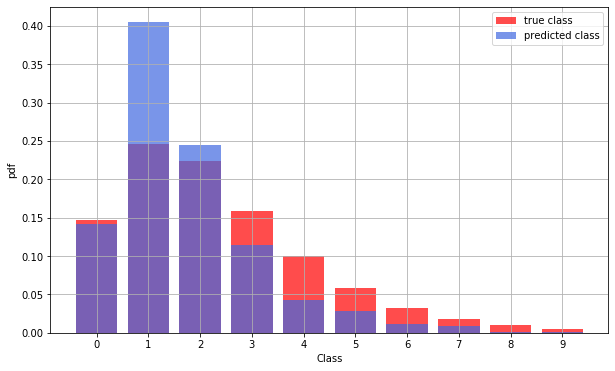

In [33]:
plt.figure(figsize=(10,6))
plt.bar(np.arange(10), y_eval.sum(axis=0)/len(y_eval), alpha=0.7, color='red', label='true class')
plt.bar(np.arange(10), y_pred_max.sum(axis=0)/len(y_pred_max), alpha=0.7, color='royalblue', label='predicted class')

plt.legend()
plt.grid()
plt.xlabel('Class')
plt.ylabel('pdf')
plt.xticks(np.arange(10))
plt.savefig('output/hist_log_max.pdf')
plt.show()

In [34]:
# centers of the bin limits (size reduced by 1)
bin_centers = np.array([(bins[i] + (bins[i+1]-bins[i])/2) for i in range(len(bins)-1)])

In [35]:
# from one-hot encoded vector label to integer
y_eval_cls = np.argmax(y_eval, axis=1)
y_pred_cls = np.argmax(y_pred_max, axis=1)
np.unique(y_eval_cls)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
# from integer label to energy
y_eval_energy = np.zeros_like(y_eval_cls)
y_pred_energy = np.zeros_like(y_pred_cls)

for i in range(len(bin_centers)):
    y_eval_energy = np.where(y_eval_cls==i, bin_centers[i], y_eval_energy)
    y_pred_energy = np.where(y_pred_cls==i, bin_centers[i], y_pred_energy)

np.unique(y_eval_energy)

array([  149.76311575,   298.81670103,   596.21770264,  1189.61071359,
        2373.58542631,  4735.92555249,  9449.41378137, 18854.05921652,
       37618.79383891, 75059.36168136])

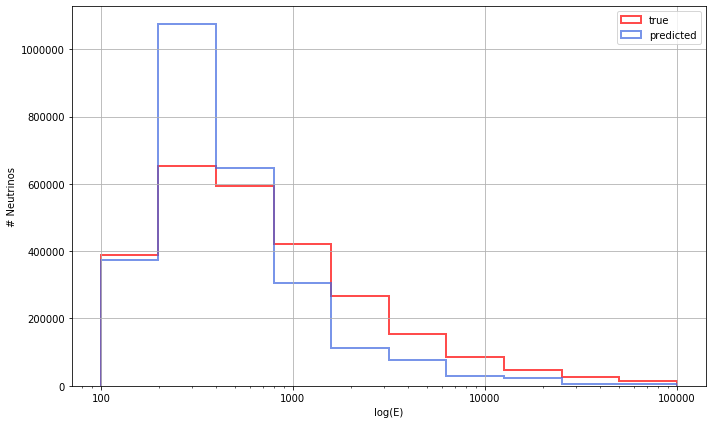

In [37]:
fig1, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(y_eval_energy, bins=bins, alpha=0.7, color='red', histtype='step', linewidth=2, label='true')
ax1.hist(y_pred_energy, bins=bins, alpha=0.7, color='royalblue', histtype='step', linewidth=2, label='predicted')


ax1.set_xscale('log')
#ax1.set_xticks(bin_centers)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel('log(E)')

ax1.set_ylabel('# Neutrinos')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('output/hist_log_energy_max.pdf')
plt.show()

In [38]:
y_pred.sum(axis=0)/len(y_pred)

array([0.13703975, 0.25407659, 0.22774489, 0.16418283, 0.09623742,
       0.05745437, 0.03086484, 0.0181695 , 0.00861646, 0.00493183])

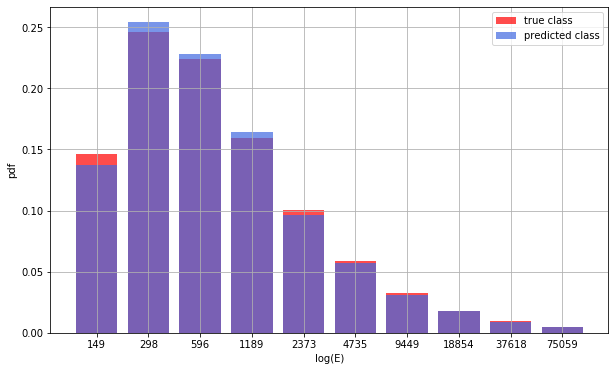

In [39]:
# now do not take the class with max prediction!
# just sum up the propabilities for each class

plt.figure(figsize=(10,6))
plt.bar(np.arange(10), y_eval.sum(axis=0)/len(y_eval), alpha=0.7, color='red', label='true class', tick_label=bin_centers.astype('int'))
plt.bar(np.arange(10), y_pred.sum(axis=0)/len(y_pred_max), alpha=0.7, color='royalblue', label='predicted class')

plt.legend()
plt.grid()
plt.xlabel('log(E)')
plt.ylabel('pdf')
plt.savefig('output/hist_log_sum.pdf')
plt.show()

In [40]:
y_pred_sum = y_pred.sum(axis=0)
y_pred_sum = np.round(y_pred_sum).astype('int')
y_pred_sum

array([363487, 673918, 604075, 435482, 255262, 152393,  81866,  48193,
        22854,  13081])

In [41]:
# to create the histogram
y_pred_sum_energy = np.array([])

for i,y in enumerate(y_pred_sum):
    y_pred_sum_energy = np.append(y_pred_sum_energy, np.ones(y)*bin_centers[i])

y_pred_sum_energy.shape, y_eval.shape

((2650611,), (2652419, 10))

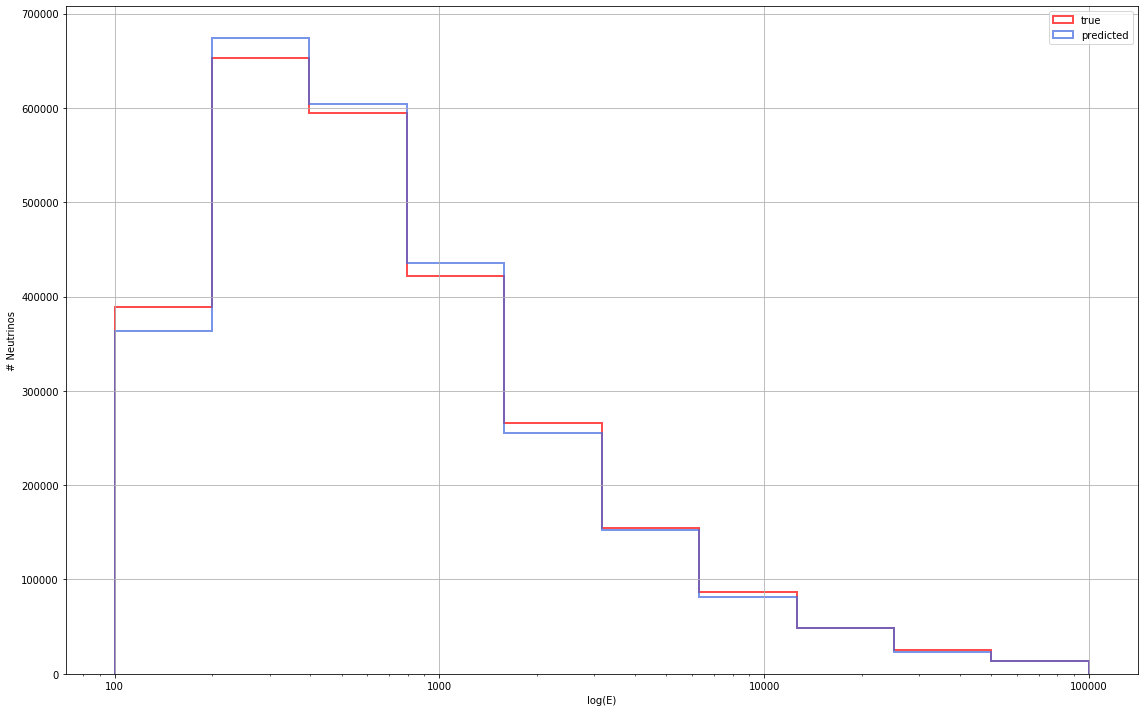

In [42]:
fig1, ax1 = plt.subplots(figsize=(16, 10))

ax1.hist(y_eval_energy, bins=bins, alpha=0.7, color='red', histtype='step', linewidth=2, label='true')
ax1.hist(y_pred_sum_energy, bins=bins, alpha=0.7, color='royalblue', histtype='step', linewidth=2, label='predicted')


ax1.set_xscale('log')
#ax1.set_xticks(bin_centers)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel('log(E)')

ax1.set_ylabel('# Neutrinos')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('output/hist_log_energy_sum.pdf')
plt.show()

## Confusion Matrix

In [149]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_eval_cls, y_pred_cls)

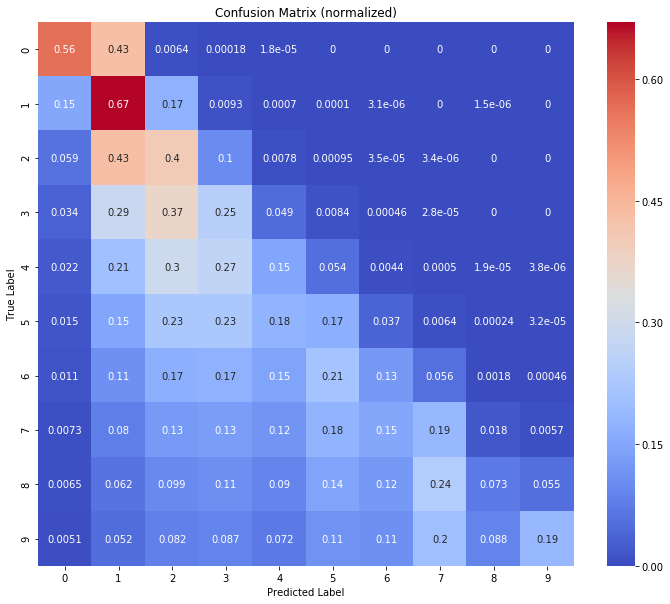

In [150]:
df_cm = pd.DataFrame(confusion_mtx/confusion_mtx.sum(axis=1)[:, np.newaxis])
plt.figure(figsize=(12,10))
#fix bug in matlotlib 3.1.0/1

ax = sns.heatmap(df_cm, annot=True, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (normalized)')
plt.savefig('output/cm_log2.pdf')
plt.show()

In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
print('Evaluation on Training data:\r')
print('Accuracy: %.4f' % accuracy_score(y_eval, y_pred_max))
print("Precision: %.4f" % precision_score(y_eval, y_pred_max, average='weighted'))
print("Recall: %.4f" % recall_score(y_eval, y_pred_max, average='weighted'))
print(classification_report(y_eval, y_pred_max))

Evaluation on Training data:
Accuracy: 0.4109
Precision: 0.4040
Recall: 0.4109
              precision    recall  f1-score   support

           0       0.58      0.56      0.57    388562
           1       0.41      0.67      0.51    652963
           2       0.37      0.40      0.38    594346
           3       0.35      0.25      0.29    421781
           4       0.34      0.15      0.21    265590
           5       0.34      0.17      0.22    154832
           6       0.36      0.13      0.19     87028
           7       0.38      0.19      0.25     48055
           8       0.45      0.07      0.13     25669
           9       0.60      0.19      0.29     13593

   micro avg       0.41      0.41      0.41   2652419
   macro avg       0.42      0.28      0.30   2652419
weighted avg       0.40      0.41      0.39   2652419
 samples avg       0.41      0.41      0.41   2652419



In [157]:
y_pred_max.shape, y_pred.shape

((2652419, 10), (2652419, 10))

In [158]:
from sklearn.metrics import jaccard_score
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
#'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account

jaccard_score = jaccard_score(y_eval, y_pred_max, average='micro')

print('Jaccard-Score: %.4f' % jaccard_score)

Jaccard-Score: 0.2586
